# Libraries

In [1]:
from tensorflow.keras.applications import VGG16
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

# VGG 16

In [2]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

# Extracting Test Features

In [3]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [4]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count, 1))
    #labels = np.zeros(shape = (sample_count, 2)) edited to two as my custom image directory has only two classes.
    generator = datagen.flow_from_directory(directory, target_size = (150, 150), batch_size = batch_size, class_mode="categorical",subset = "training")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [5]:
test_dir = 'TestImg/Test'

In [13]:
model = load_model('Models/YogaPoseClassifierRegularCustomDB.h5')

In [14]:
test_features, test_labels = extract_features(test_dir, 5)

Found 5 images belonging to 1 classes.


In [15]:
test_features = np.reshape(test_features, (5, 4 * 4 * 512))

In [16]:
output_class = model.predict(test_features)

In [17]:
for output in output_class:
    print(output)

[0.00779334 0.00659275 0.00771177 0.00233    0.9755721 ]
[4.7607318e-04 9.7069812e-01 2.7960434e-04 9.8298844e-03 1.8716406e-02]
[7.1336125e-04 2.2397162e-02 1.5621496e-04 9.7458309e-01 2.1501130e-03]
[6.8343878e-05 3.6468740e-05 9.9982363e-01 1.4438976e-05 5.7189558e-05]
[9.9931848e-01 7.9473139e-06 3.5745726e-04 9.1752427e-06 3.0683077e-04]


# Converting Numeric Output to String

In [18]:
direc = 'DataBaseCustom/DATASET/TRAIN'
poses = os.listdir(direc)
print(poses)

['goddess', 'halfMoon', 'tree', 'triangle', 'warrior2']


In [19]:
def output_pose(array):
    max_val = max(array)
    pos = -1
    for i, val in enumerate(array):
        if val == max_val:
            pos = i
            break
    return poses[pos]

In [20]:
for output in output_class:
    print(output_pose(output))

warrior2
halfMoon
triangle
tree
goddess


# Custom CNN on Open Pose Only

In [14]:
model = load_model('Models/YogaPoseClassifierCNNBlack.h5')

# Converting Images to Open Pose Only

In [15]:
test_dir = 'TestImg'
store_dir = test_dir + '/test_black/Test'


In [16]:
load_dir = test_dir + '/Test/Test'

In [17]:
output_dir = test_dir + '/test_op'


In [ ]:
os.mkdir(store_dir)
os.mkdir(output_dir)

In [18]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

In [19]:
img_array = []
for filename in os.listdir(load_dir):
    img_array.append(load_dir + '/' + filename)

In [20]:
print(img_array)

['TestImg/Test/Test/00000000.jpg', 'TestImg/Test/Test/00000071.jpg', 'TestImg/Test/Test/00000096.jpg', 'TestImg/Test/Test/00000140.jpg', 'TestImg/Test/Test/00000147.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


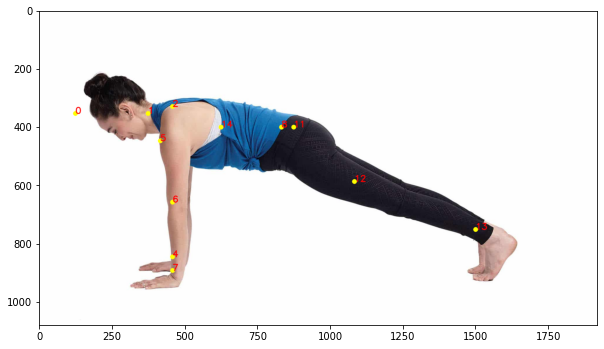

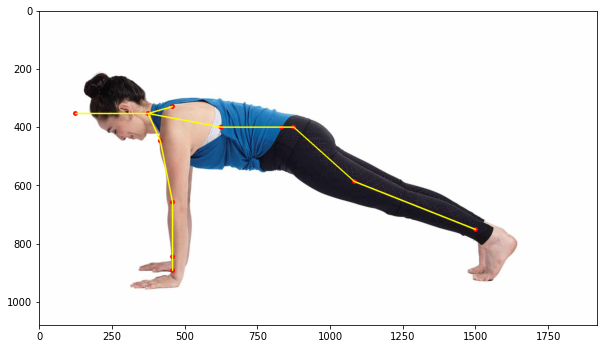

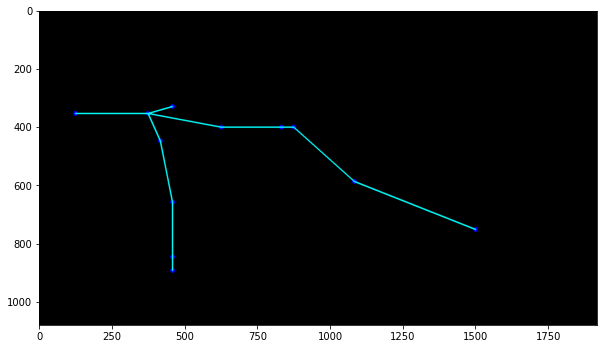

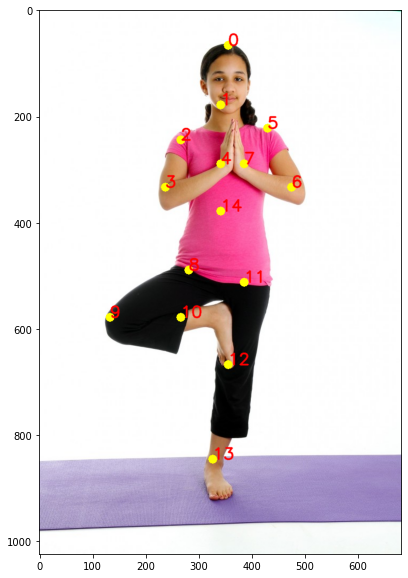

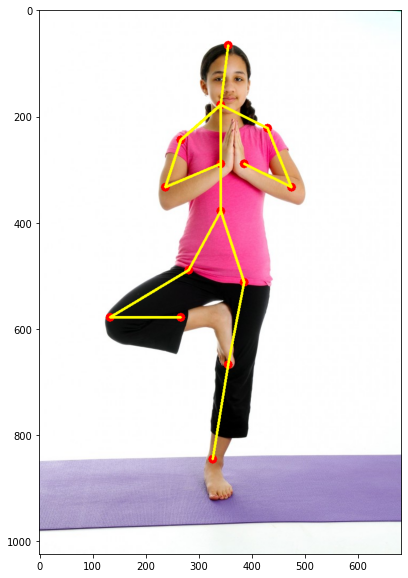

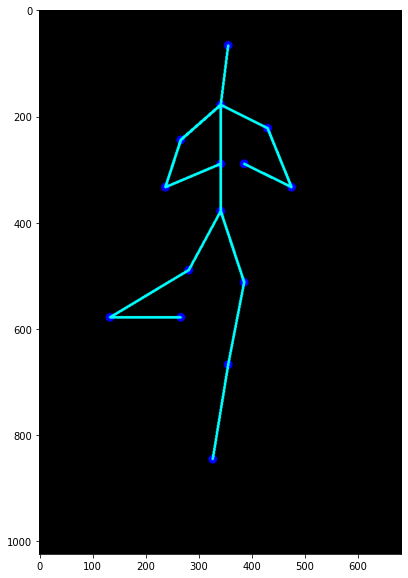

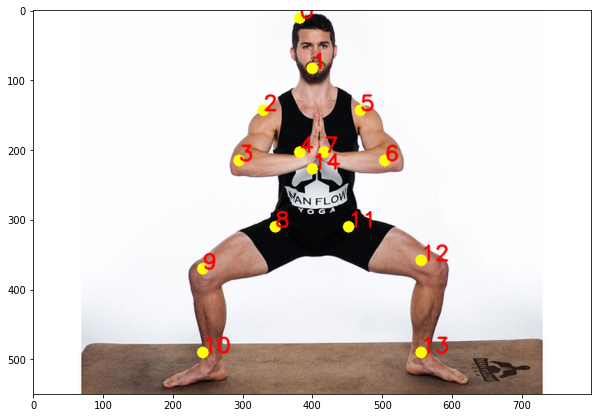

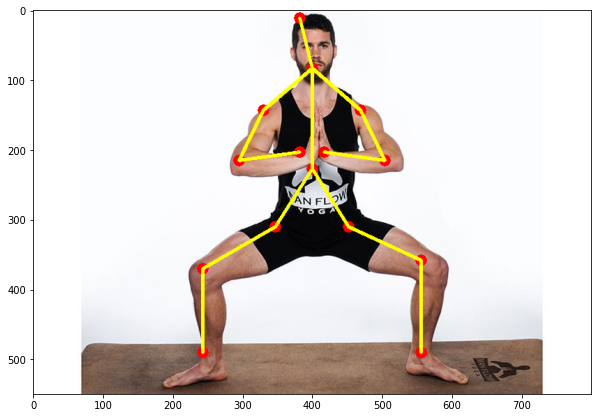

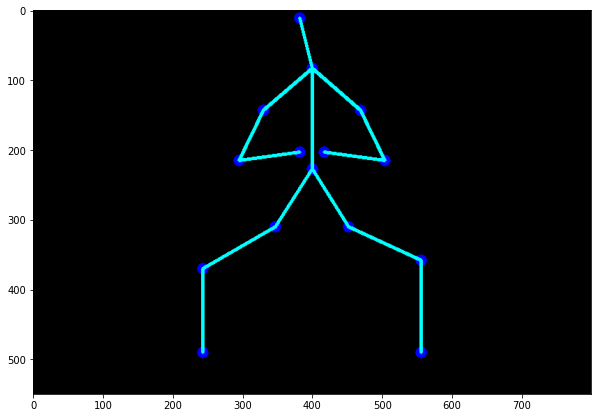

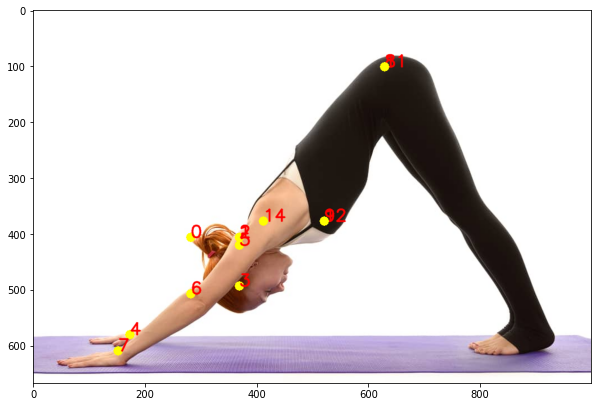

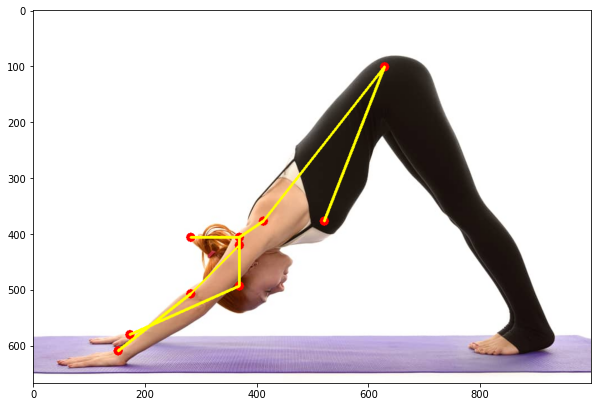

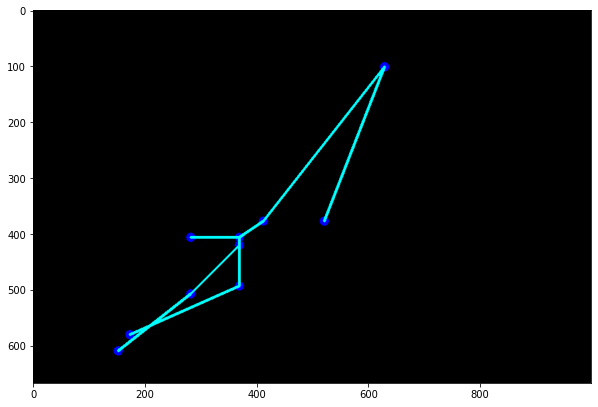

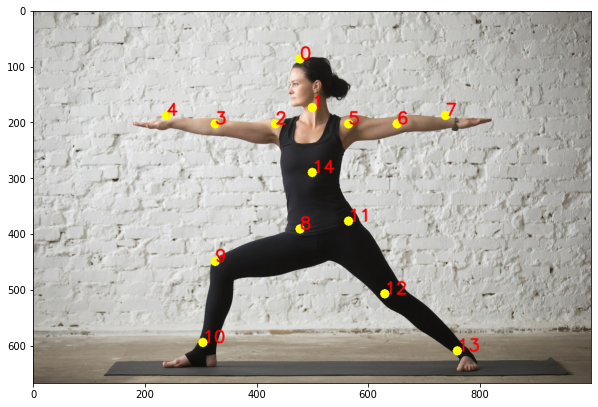

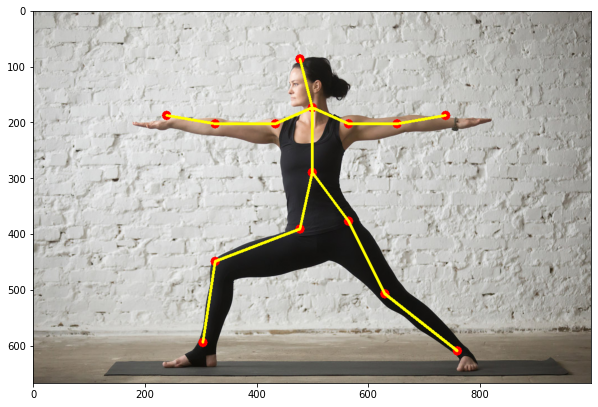

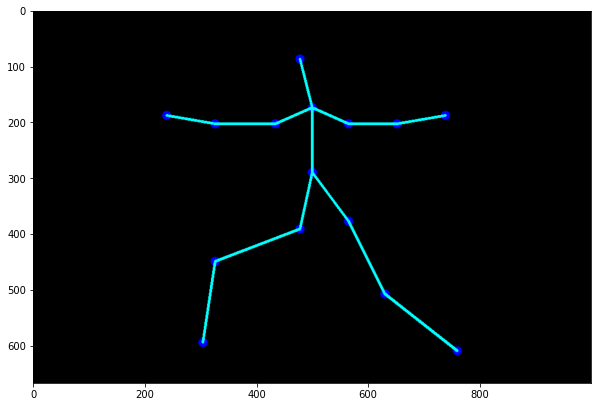

In [21]:
for count, img in enumerate(img_array):
    frame = cv2.imread(img)
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    black_canvas = np.zeros(shape = (frameHeight, frameWidth, 3))
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)

    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]
    
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(black_canvas, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
            cv2.line(black_canvas, points[partA], points[partB], (0, 255, 255), 3)

    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cv2.imwrite(output_dir + '/img_' + str(count) + '.jpg', frame)
    plt.figure(figsize=[10,10])
    plt.imshow(black_canvas)
    cv2.imwrite(store_dir + '/img_' + str(count) + '.jpg', black_canvas)

In [22]:
test_datagen = ImageDataGenerator(1./255)

In [23]:
test_dir = test_dir + '/test_black'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'categorical')

Found 5 images belonging to 1 classes.


In [24]:
output_classes = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


C:\Users\Dhananjay\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [25]:
for output in output_classes:
    print(output_pose(output))

warrior2
downdog
tree
plank
goddess
